# HT 7. Tensorflow2

**MINERÍA DE DATOS - SECCIÓN - 20 - 2024 - 1**

Samuel Chamalé, 21881

Renatto Guzmán, 21646

---


In [5]:
# Importando las librerías necesarias para las simulaciones
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold

In [6]:
%matplotlib inline

In [17]:
def simpleLinearRegression(observaciones=1000, learning_rate=0.02, epochs=100, loss='mean_squared_error'):
    # Definición de las variables y el modelo según el código proporcionado en el ejemplo
    # Generando datos aleatorios para x1 y x2
    x1 = np.random.uniform(low=-10, high=10, size=(observaciones, 1))
    x2 = np.random.uniform(-10, 10, (observaciones, 1))
    X = np.column_stack((x1, x2))

    ruido = np.random.uniform(-1, 1, (observaciones, 1))

    y = 2 * x1 - 3 * x2 + 5 + ruido

    np.savez('DatosRegression', inputs=X, targets=y)
    datos = np.load('DatosRegression.npz')

    tamanio_entrada = 2
    tamanio_salida = 1

    modelo = tf.keras.Sequential([
        tf.keras.layers.Dense(
            tamanio_salida,
            kernel_initializer=tf.random_uniform_initializer(
                minval=-0.1, maxval=0.1),
            bias_initializer=tf.random_uniform_initializer(
                minval=-0.1, maxval=0.1)
        )
    ])

    optimizador_adhoc = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    if loss == 'huber_loss':
        use_loss = tf.keras.losses.Huber()
    else:
        use_loss = loss

    modelo.compile(optimizer=optimizador_adhoc,
                   loss=use_loss)

    modelo.fit(datos['inputs'], datos['targets'], epochs=epochs, verbose=0)

    pesos = modelo.layers[0].get_weights()[0]
    sesgos = modelo.layers[0].get_weights()[1]

    plt.figure(figsize=(10, 10))
    plt.plot(np.squeeze(modelo.predict_on_batch(datos['inputs'])),
             np.squeeze(datos['targets']), color='red')
    plt.suptitle('Predicciones vs Metas Reales', fontsize=20)
    plt.title(
        f"[observaciones={observaciones}, learning_rate={learning_rate}, epochs={epochs}, loss={loss}] [pesos={np.squeeze(pesos)} sesgos={np.squeeze(sesgos)}]"
    )

    plt.xlabel('Prediciones')
    plt.ylabel('Metas Reales')
    plt.show()

In [5]:
def simpleLinearRegressionCrossValidated(observaciones=1000, learning_rate=0.02, epochs=100, loss='mean_squared_error', n_splits=5):
    # Generando datos aleatorios para x1 y x2
    x1 = np.random.uniform(low=-10, high=10, size=(observaciones, 1))
    x2 = np.random.uniform(-10, 10, (observaciones, 1))
    X = np.column_stack((x1, x2))

    ruido = np.random.uniform(-1, 1, (observaciones, 1))
    y = 2 * x1 - 3 * x2 + 5 + ruido
    # Convert targets to binary (0 or 1) for precision calculation
    y = (y > np.median(y)).astype(int)

    # Configuración de KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    resultados = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        tamanio_entrada = 2
        tamanio_salida = 1

        modelo = tf.keras.Sequential([
            tf.keras.layers.Dense(tamanio_salida,
                                  kernel_initializer=tf.random_uniform_initializer(
                                      minval=-0.1, maxval=0.1),
                                  bias_initializer=tf.random_uniform_initializer(
                                      minval=-0.1, maxval=0.1),
                                  activation='sigmoid')  # Use sigmoid for binary classification
        ])

        optimizador_adhoc = tf.keras.optimizers.SGD(
            learning_rate=learning_rate)

        if loss == 'huber_loss':
            use_loss = tf.keras.losses.Huber()
        else:
            use_loss = loss

        # Compile model with precision as a metric
        modelo.compile(optimizer=optimizador_adhoc, loss=use_loss, metrics=[
                       tf.metrics.BinaryAccuracy(), tf.metrics.Precision()])

        modelo.fit(X_train, y_train, epochs=epochs, verbose=0)

        # Evaluar el modelo
        loss_c, accuracy, precision = modelo.evaluate(
            X_test, y_test, verbose=0)
        print(
            f"Loss: {loss_c}, Accuracy: {accuracy}, Precision: {precision} en esta iteración")

        # Almacenar resultados para el análisis posterior
        resultados.append((loss_c, accuracy, precision))

    # Reportar la precisión y pérdida media
    print("Resultados finales de validación cruzada:", resultados)
    print("Promedio de la pérdida:", np.mean([r[0] for r in resultados]))
    print("Promedio de la precisión:", np.mean([r[2] for r in resultados]))

## 1. Optimización de Hiperparámetros:


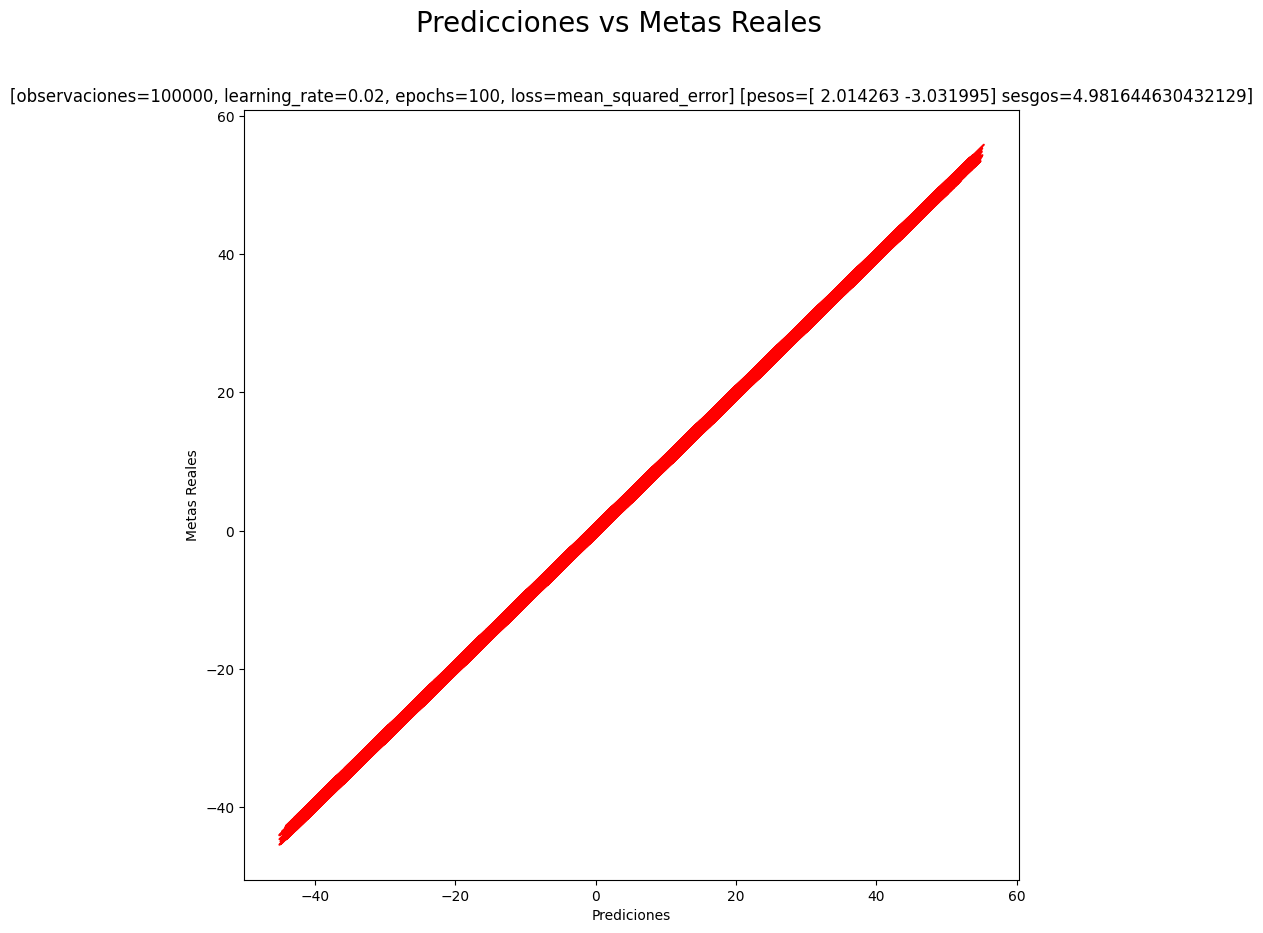

In [8]:
# Cambie el número de observaciones a 100,000. Este no es un hiperparámetro
# pero puede afectar el rendimiento del modelo. ¿Qué ocurre?
simpleLinearRegression(100000)

<Sequential name=sequential_3, built=False>


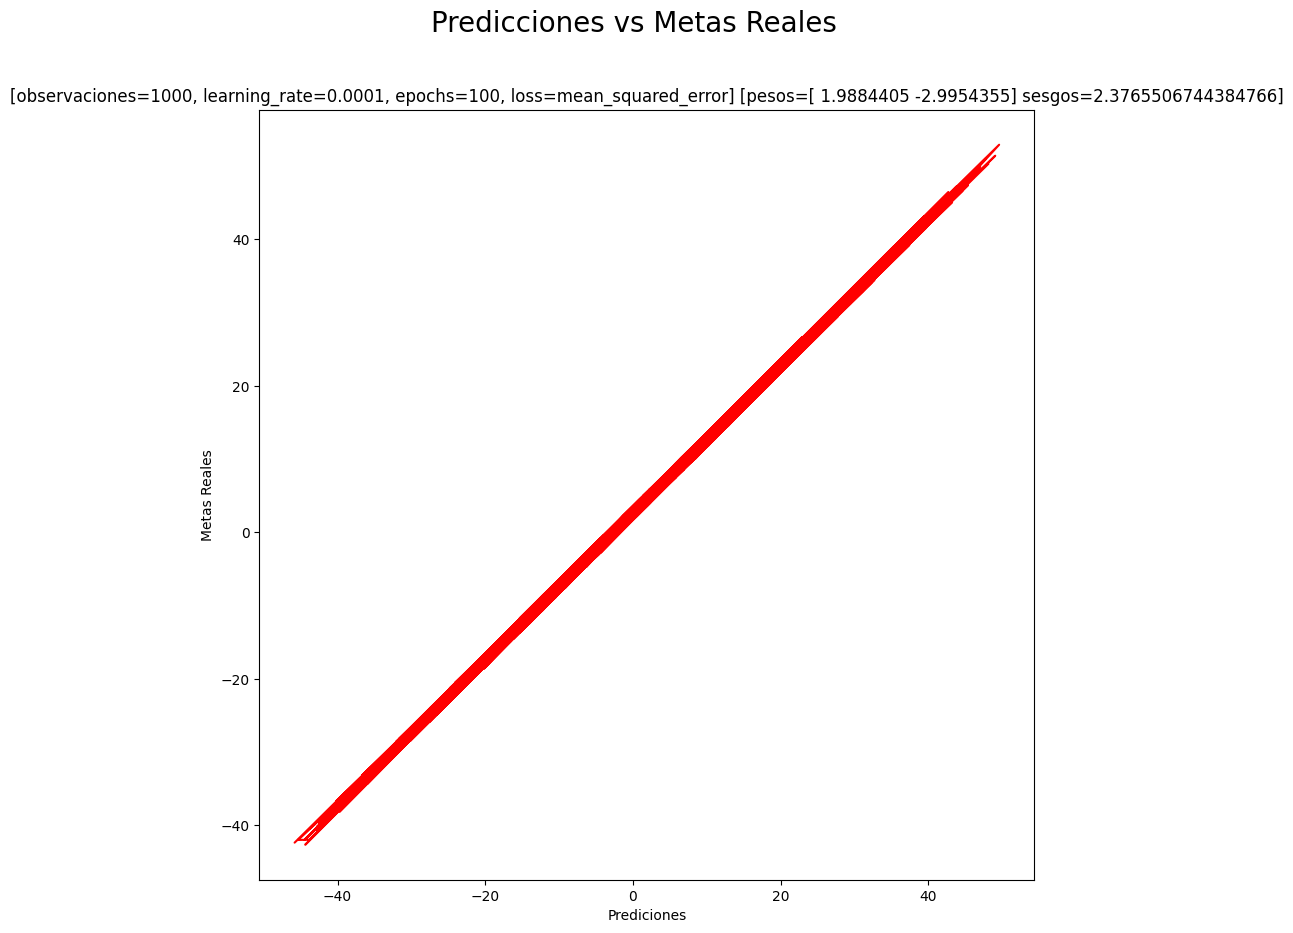

<Sequential name=sequential_4, built=False>


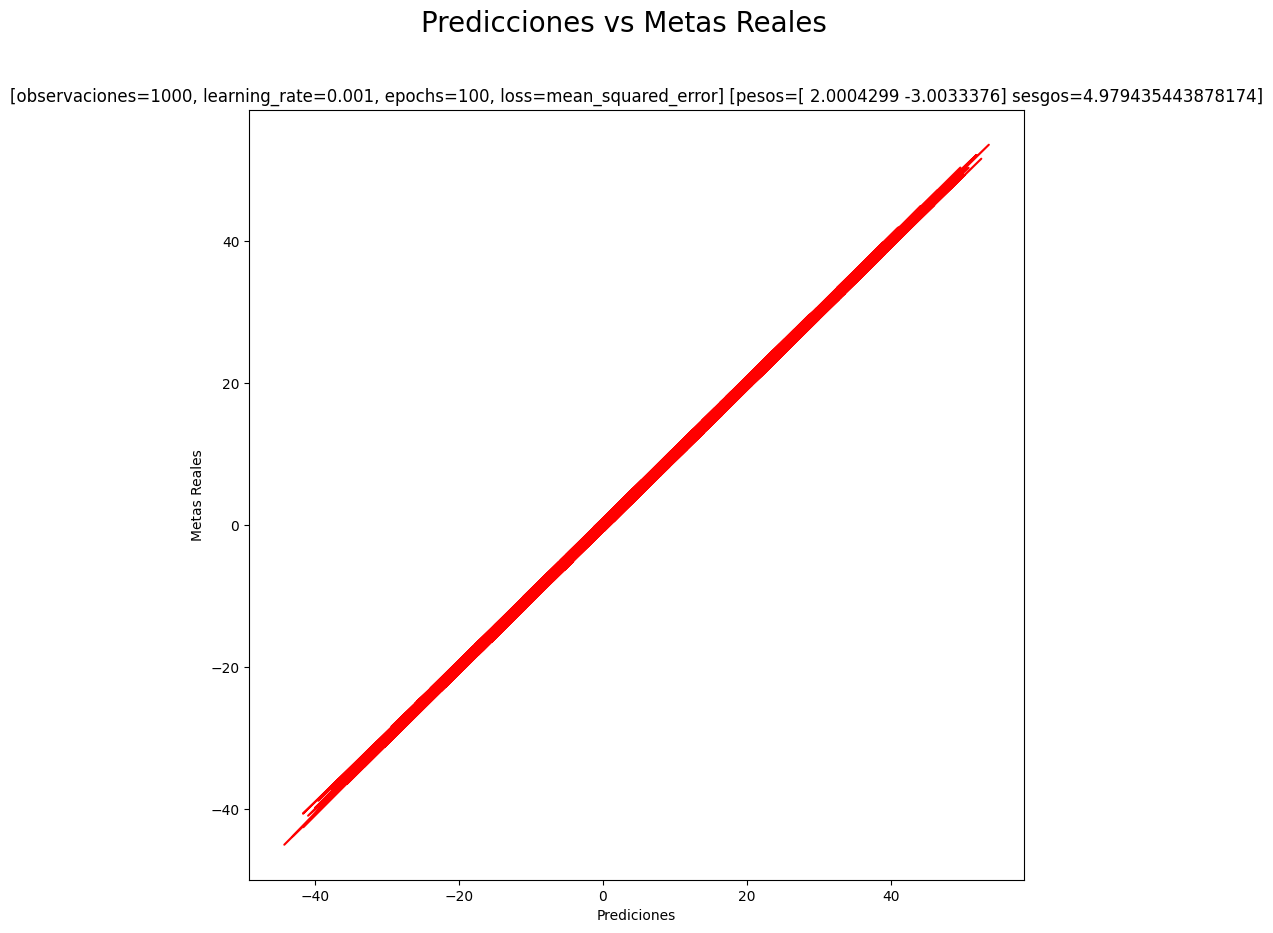

<Sequential name=sequential_5, built=False>


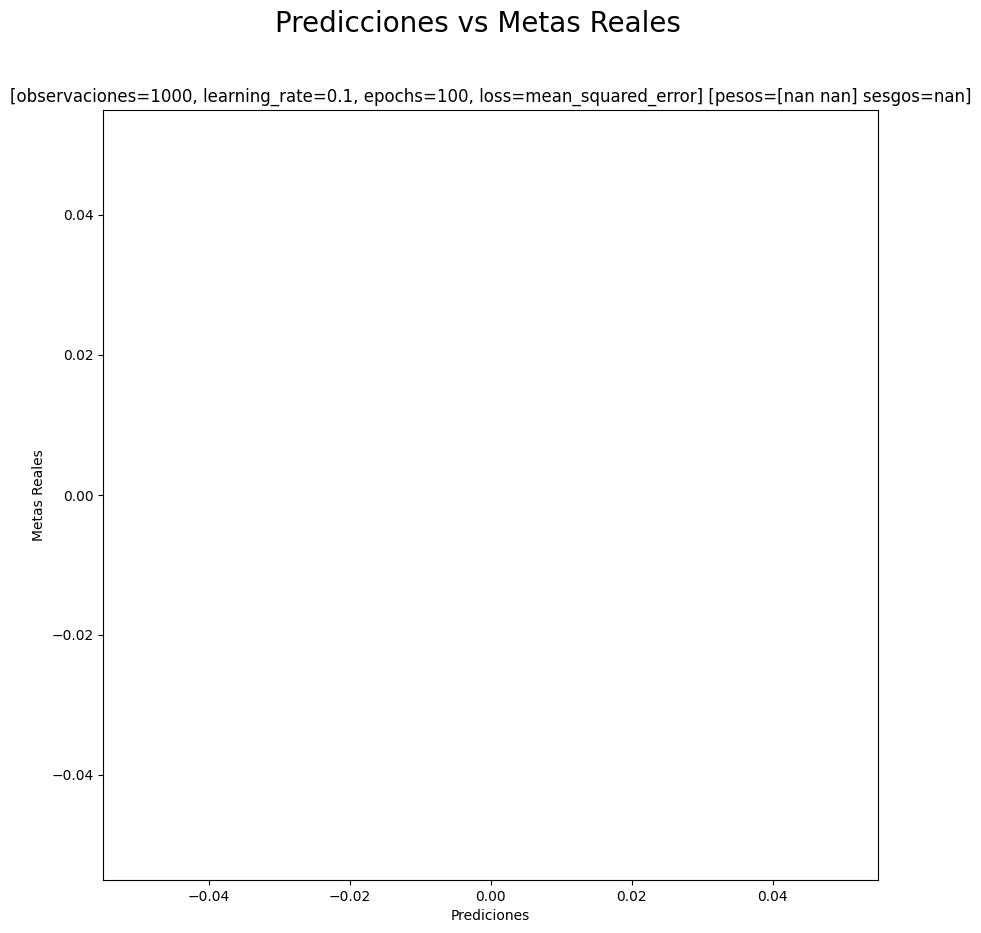

<Sequential name=sequential_6, built=False>


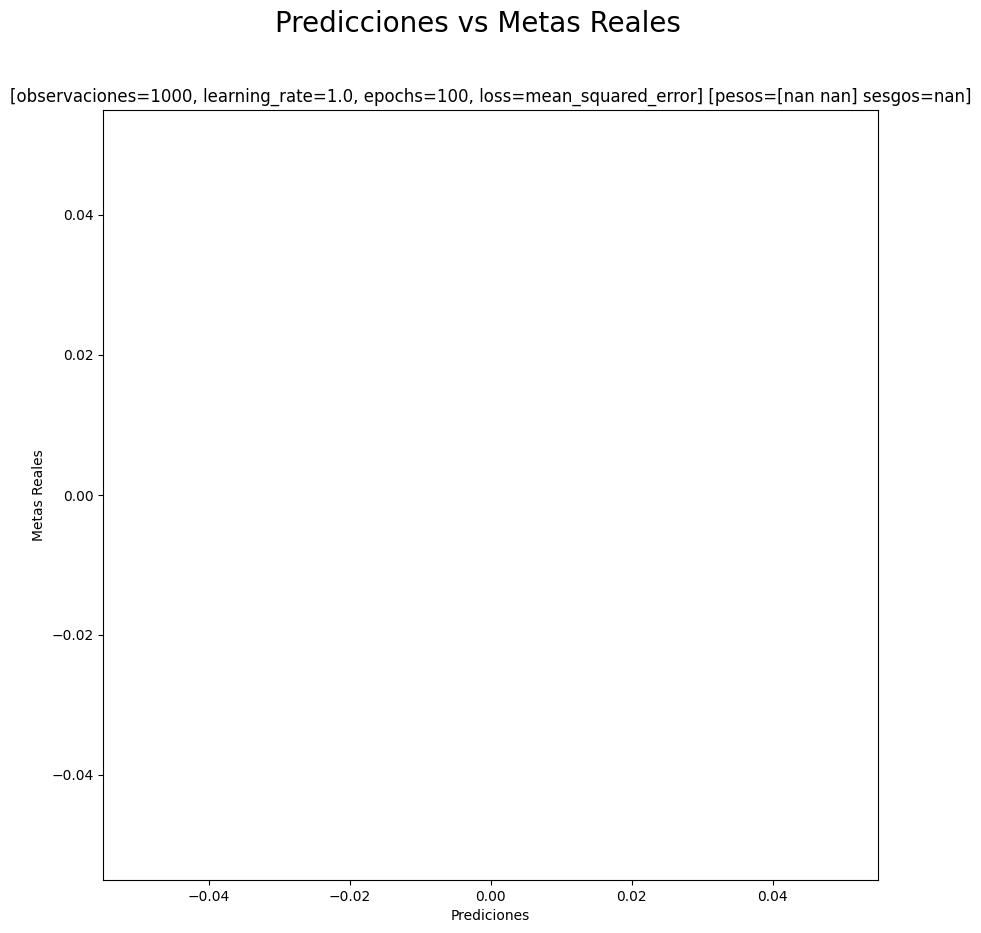

In [10]:
# Experimente con diferentes valores para la tasa de aprendizaje. Los valores como
# 0.0001, 0.001, 0.1, 1 son interesantes para observar.
for learning_rate in [0.0001, 0.001, 0.1, 1.0]:
    simpleLinearRegression(learning_rate=learning_rate)

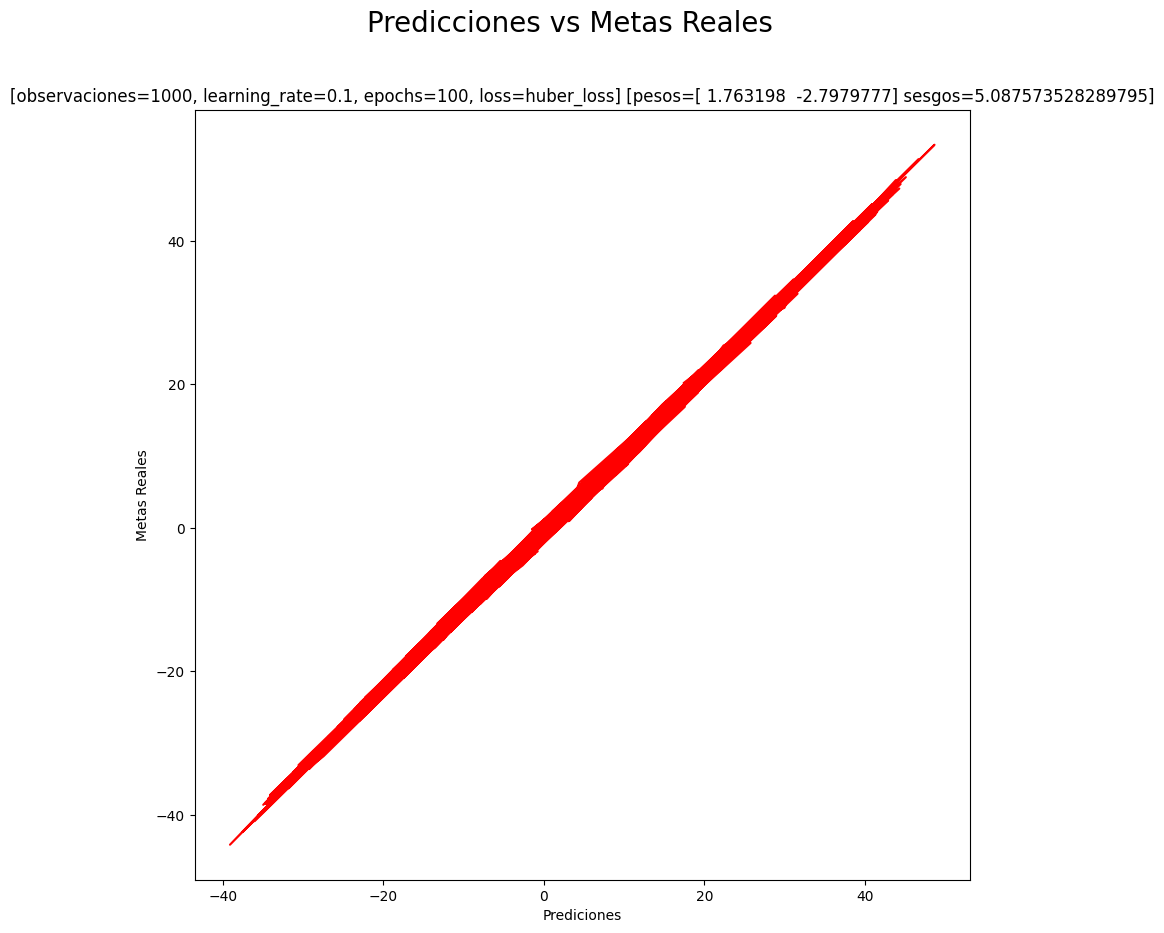

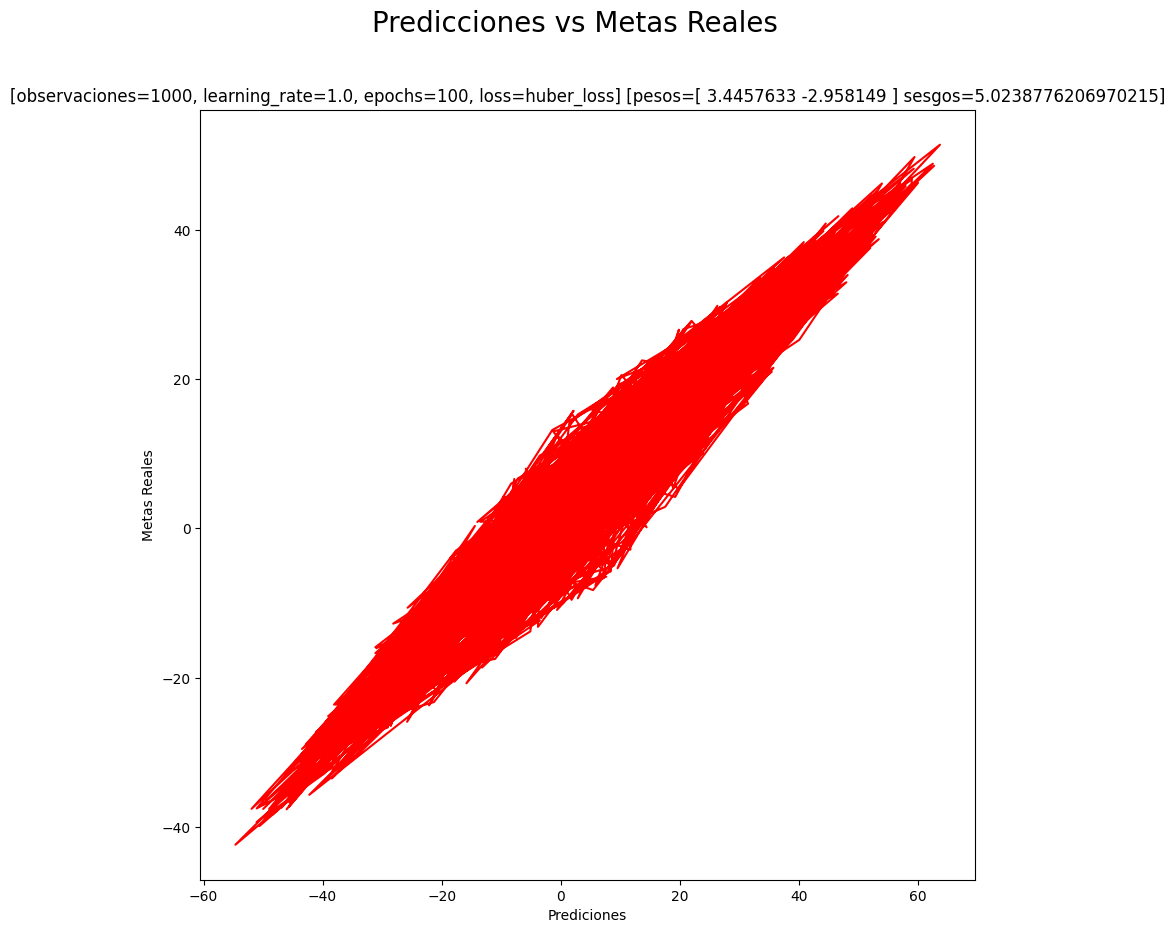

In [18]:
for learning_rate in [0.1, 1.0]:
    simpleLinearRegression(learning_rate=learning_rate, loss='huber_loss')

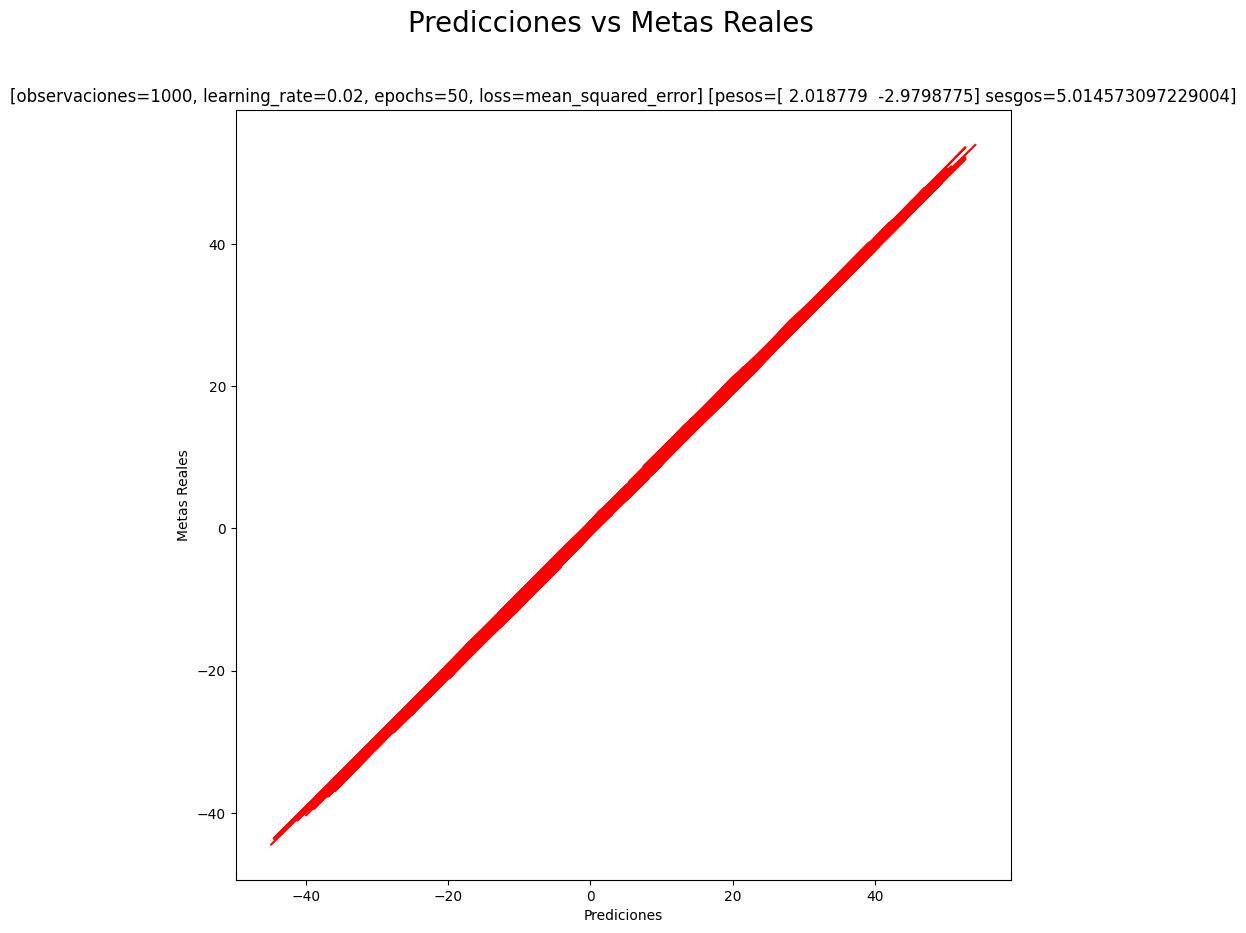

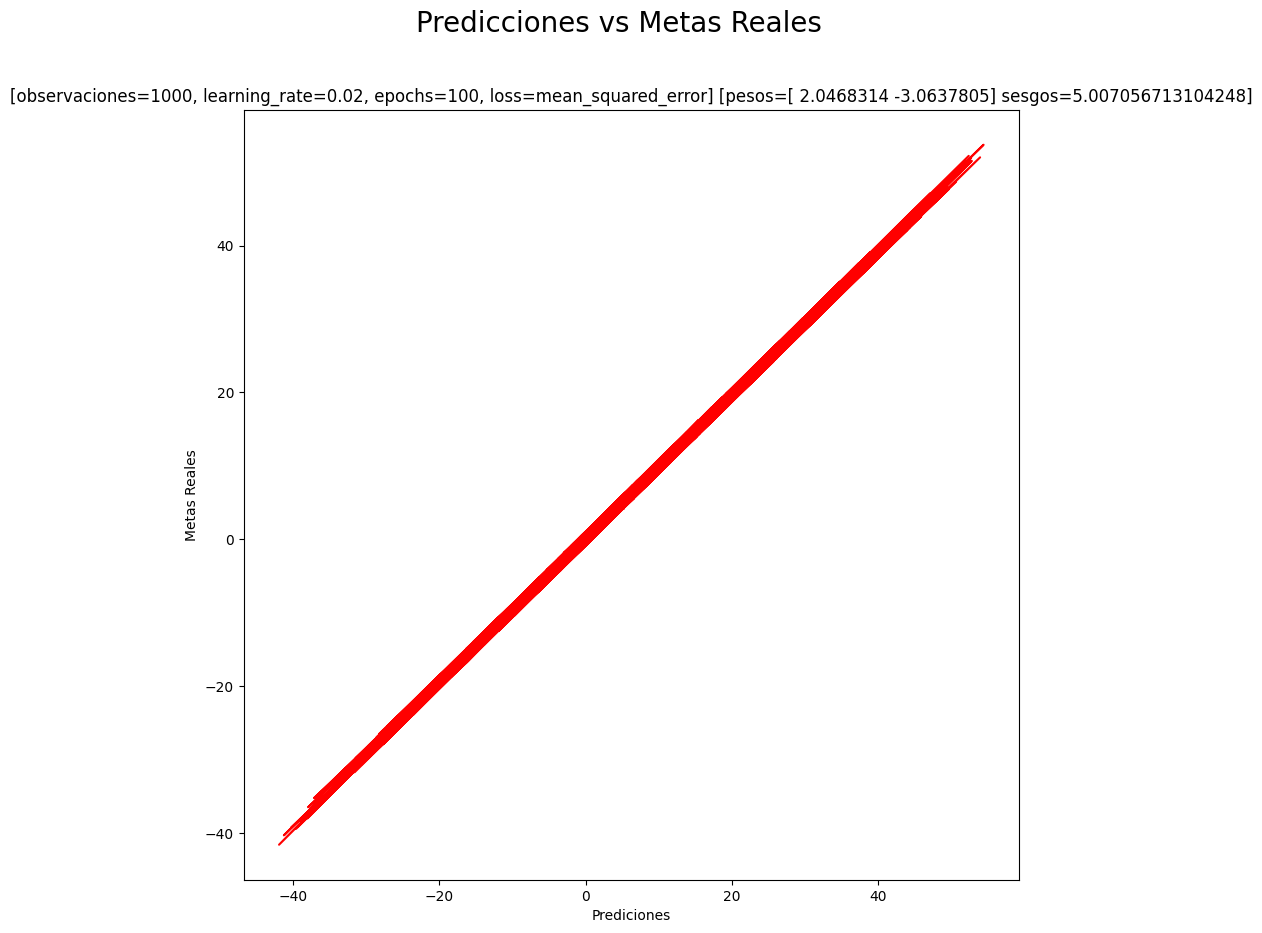

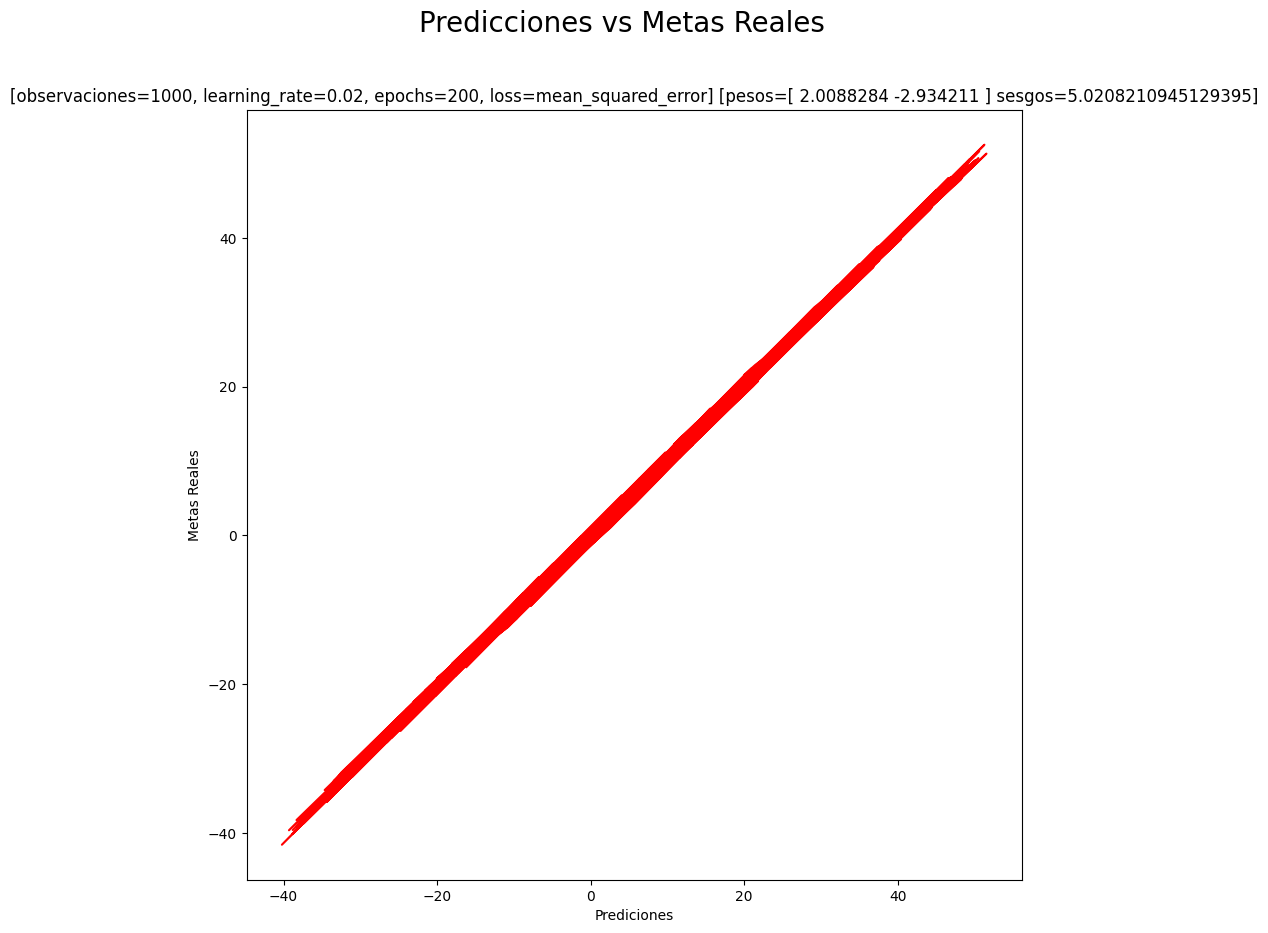

In [7]:
# Prueba también cambiando
# el número de épocas (50, 100, 200). ¿Qué diferencias se observan? ¿Se
# comporta bien el algoritmo?
for epochs in [50, 100, 200]:
    simpleLinearRegression(epochs=epochs)

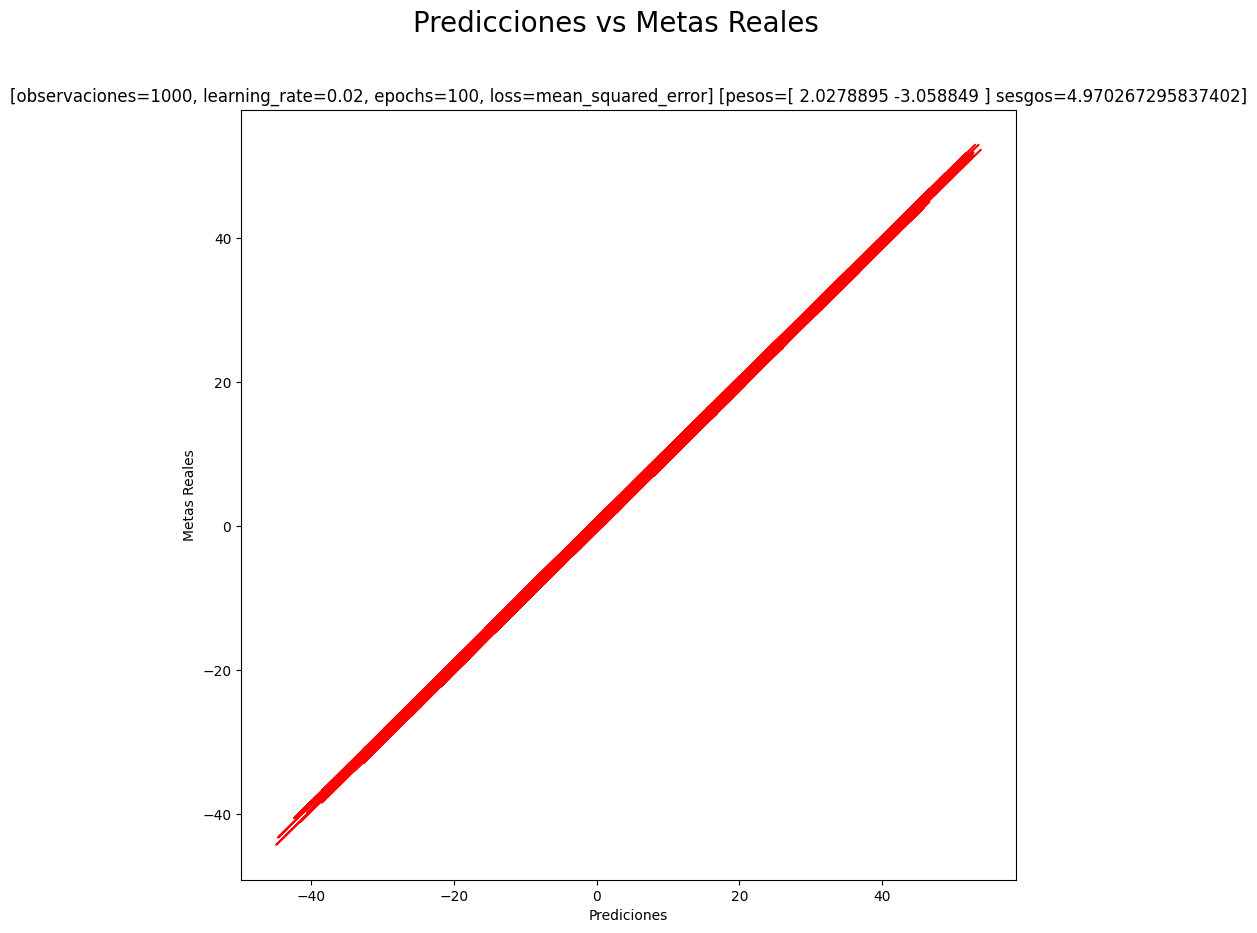

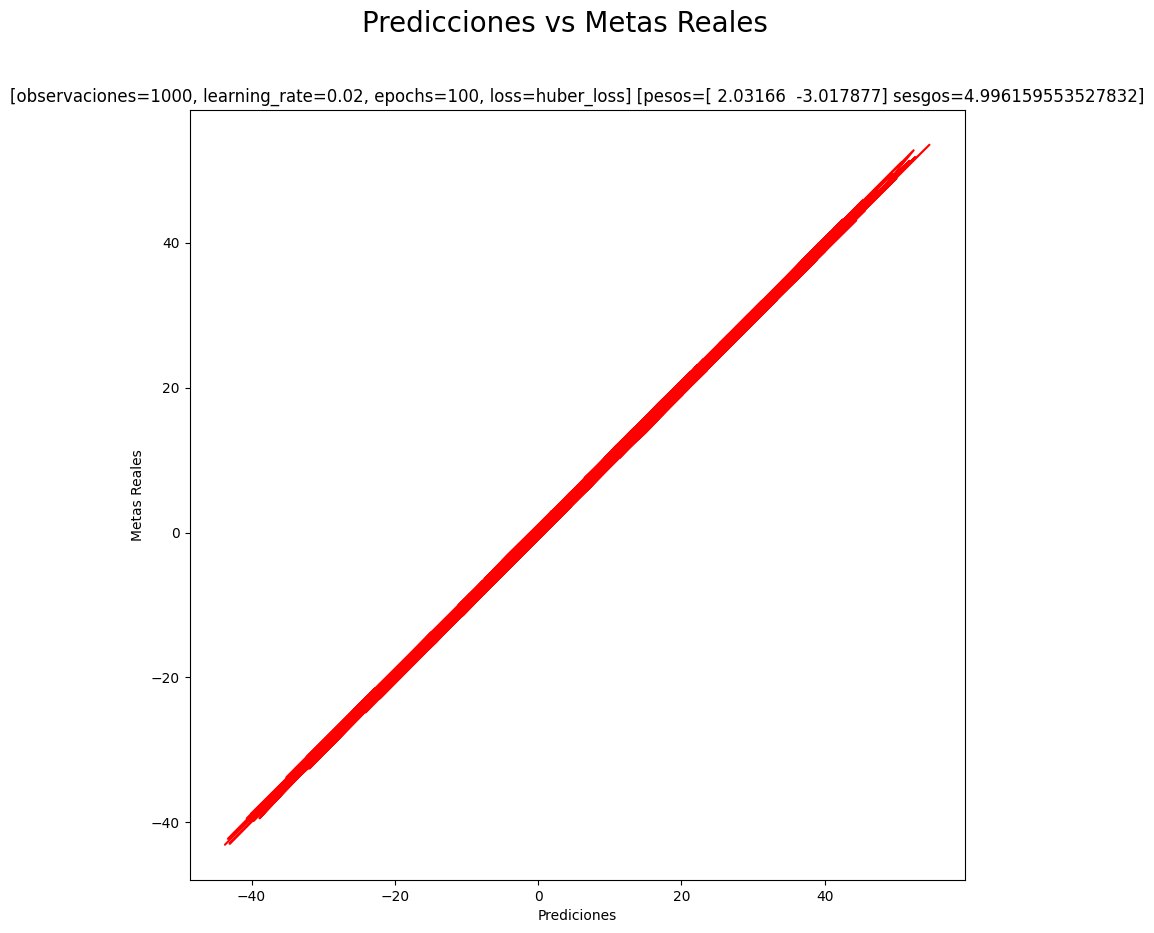

In [14]:
# Cambie la función de pérdida. ¿Cómo se comparan los resultados al cambiar la
# función de pérdida? Una función alternativa es la “Huber Loss”.
for loss in ['mean_squared_error', 'huber_loss']:
    simpleLinearRegression(loss=loss)

## 2. Validación Cruzada


- Implemente una técnica de validación cruzada para evaluar la estabilidad y la generalización del modelo.


In [15]:
simpleLinearRegressionCrossValidated()

Loss: 0.01711207814514637, Accuracy: 0.9950000047683716, Precision: 0.9895833134651184 en esta iteración
Loss: 0.020797304809093475, Accuracy: 0.9850000143051147, Precision: 1.0 en esta iteración
Loss: 0.015637537464499474, Accuracy: 0.9900000095367432, Precision: 0.9826086759567261 en esta iteración
Loss: 0.015295970253646374, Accuracy: 0.9900000095367432, Precision: 0.9801980257034302 en esta iteración
Loss: 0.01342760119587183, Accuracy: 0.9950000047683716, Precision: 0.9896907210350037 en esta iteración
Resultados finales de validación cruzada: [(0.01711207814514637, 0.9950000047683716, 0.9895833134651184), (0.020797304809093475, 0.9850000143051147, 1.0), (0.015637537464499474, 0.9900000095367432, 0.9826086759567261), (0.015295970253646374, 0.9900000095367432, 0.9801980257034302), (0.01342760119587183, 0.9950000047683716, 0.9896907210350037)]
Promedio de la pérdida: 0.016454098373651506
Promedio de la precisión: 0.9884161472320556


## 3. Interpretación de Resultados


### Interpretación final de Resultados

De los resultados obtenidos para la `Optimización de hiperparámetros` y `Validación Cruzada`, se observa lo siguiente:

- **Optimización de Hiperparámetros**

Al cambiar el número de observaciones a 100,000 se puede ver un resultado bastante similar a que si tuviera menos observaciones aunque con un nivel mayor de precisión aunque el tiempo de ejecución de la función es significantemente mayor.

Las tasas de aprendizaje 0.0001 y 0.001 demuestran los resultados más óptimos de los probados, ya que al probar con una tasa de 0.1 y 1 no se puede observar resultados en la gráfica ya que un learning rate muy alto puede causar que el entrenamiento oscile o incluso diverja, ya que los ajustes a los pesos y sesgos son demasiado grandes y el modelo no puede converger a una solución óptima.

En nuestro caso una tasa de aprendizaje muy alta puede causar que los ajustes de los pesos y los sesgos sean demasiado grandes, lo que impide que el algoritmo de optimización converja a un mínimo global o local de la función de pérdida. En lugar de eso, los pesos pueden oscilar descontroladamente o divergir hacia valores extremos, lo que significa que el modelo ya no está aprendiendo efectivamente. Consecuentemente no obtenemos valores para gráficar. Cabe destacar que se observó que este comportamiento solo sucede con la función MSR, y al utilizar alguna como Huber Loss inclusive utilizando la misma tasa de aprendizaje los valores, aunque no óptimos, no desembocaban en NaN. Lo que sugiere que al utilizar la función MSR los valores se aproximan a cero y resultan en indeterminados.

Con repecto a las épocas se observa que con 50 épocas el algoritmo funciona correctamente y es suficiente para que el modelo aprenda patrones de los datos, aunque con más épocas como con 100 o 200 no se sobreajusta y muestra resultados muy similares, pero no son necesarias tantas épocas.

Se logra ver que el efecto de la función de Huber Loss no es muy grande ya que esta funciona mejor cuando se desea reducir el impacto de muchos valores atípicos que este modelo no muestra y funciona bastante bien con la función de Mean Squared Error. Pero podrá ser útil para el futuro en el caso de encontrarnos con muchos casos atípicos y querer cambiar de cuadrático a lineal para no penalizar mucho estos casos.

- **Validación cruzada** La validación cruzada muestra resultados muy buenos con una precisión promedio de 0.9884 y una pérdida de 0.0165 lo que muestra que el modelo ha aprendido de manera efectiva los patrones presentes en los datos de entrenamiento y es capaz de aplicar ese conocimiento a nuevos datos sin sobreajustarse.

### Conclusión

La optimización de hiperparámetros reveló que tasas de aprendizaje bajas (0.0001 y 0.001) y un número moderado de épocas (50) proporcionan los mejores resultados, evitando problemas como divergencia o sobreajuste. Si bien un mayor número de observaciones mejora ligeramente la precisión, el costo computacional adicional puede no ser justificable.

La función de pérdida cuadrática media funcionó adecuadamente, aunque la pérdida de Huber podría ser útil en caso de encontrar muchos valores atípicos en el futuro.

Los excelentes resultados de la validación cruzada, demuestran que el modelo ha aprendido patrones generalizables de los datos y no sufre de sobreajuste significativo. Esto brinda confianza en que el modelo mantendrá un desempeño similar cuando se implemente con datos nuevos en un entorno de producción.
